In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/pdf_parsing

/content/drive/MyDrive/pdf_parsing


In [ ]:
!pip install layoutparser

In [ ]:
!pip install "layoutparser[effdet]"

In [ ]:
!pip install layoutparser torchvision && pip install "git+https://github.com/facebookresearch/detectron2.git@v0.5#egg=detectron2"

In [ ]:
!pip install "layoutparser[paddledetection]"

In [ ]:
!pip install "layoutparser[ocr]"

In [ ]:
!pip install google-cloud-vision==1.0.2

In [22]:
import cv2

# 이미지 불러오기
image = cv2.imread("./eng_business_report.jpg")
image = image[..., ::-1]

# Image Segmentation을 위한 모델 Detectron2 적용

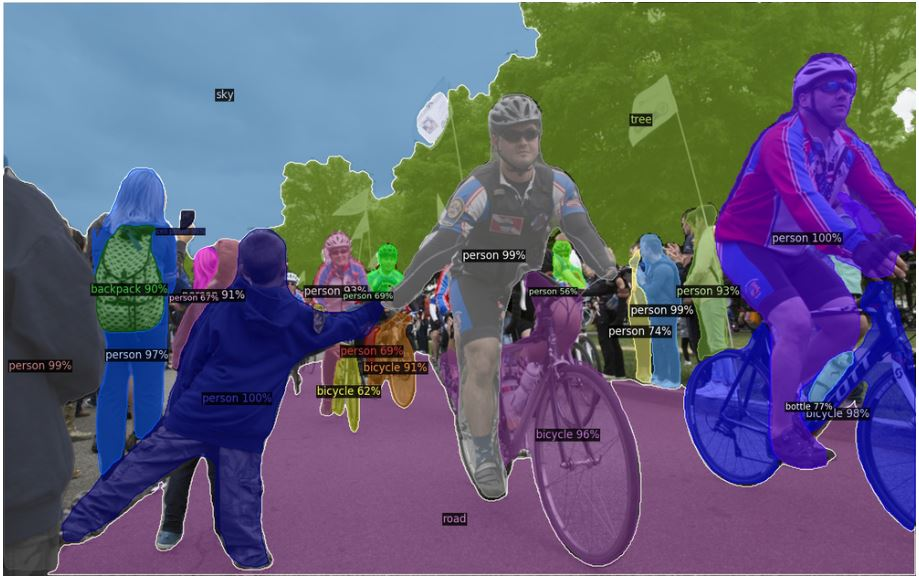

In [24]:
import layoutparser as lp

# Model 생성
model = lp.Detectron2LayoutModel('lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config',extra_config = ["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.65],
                                 label_map = {0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})
# Layout 감지
layout = model.detect(image)

  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


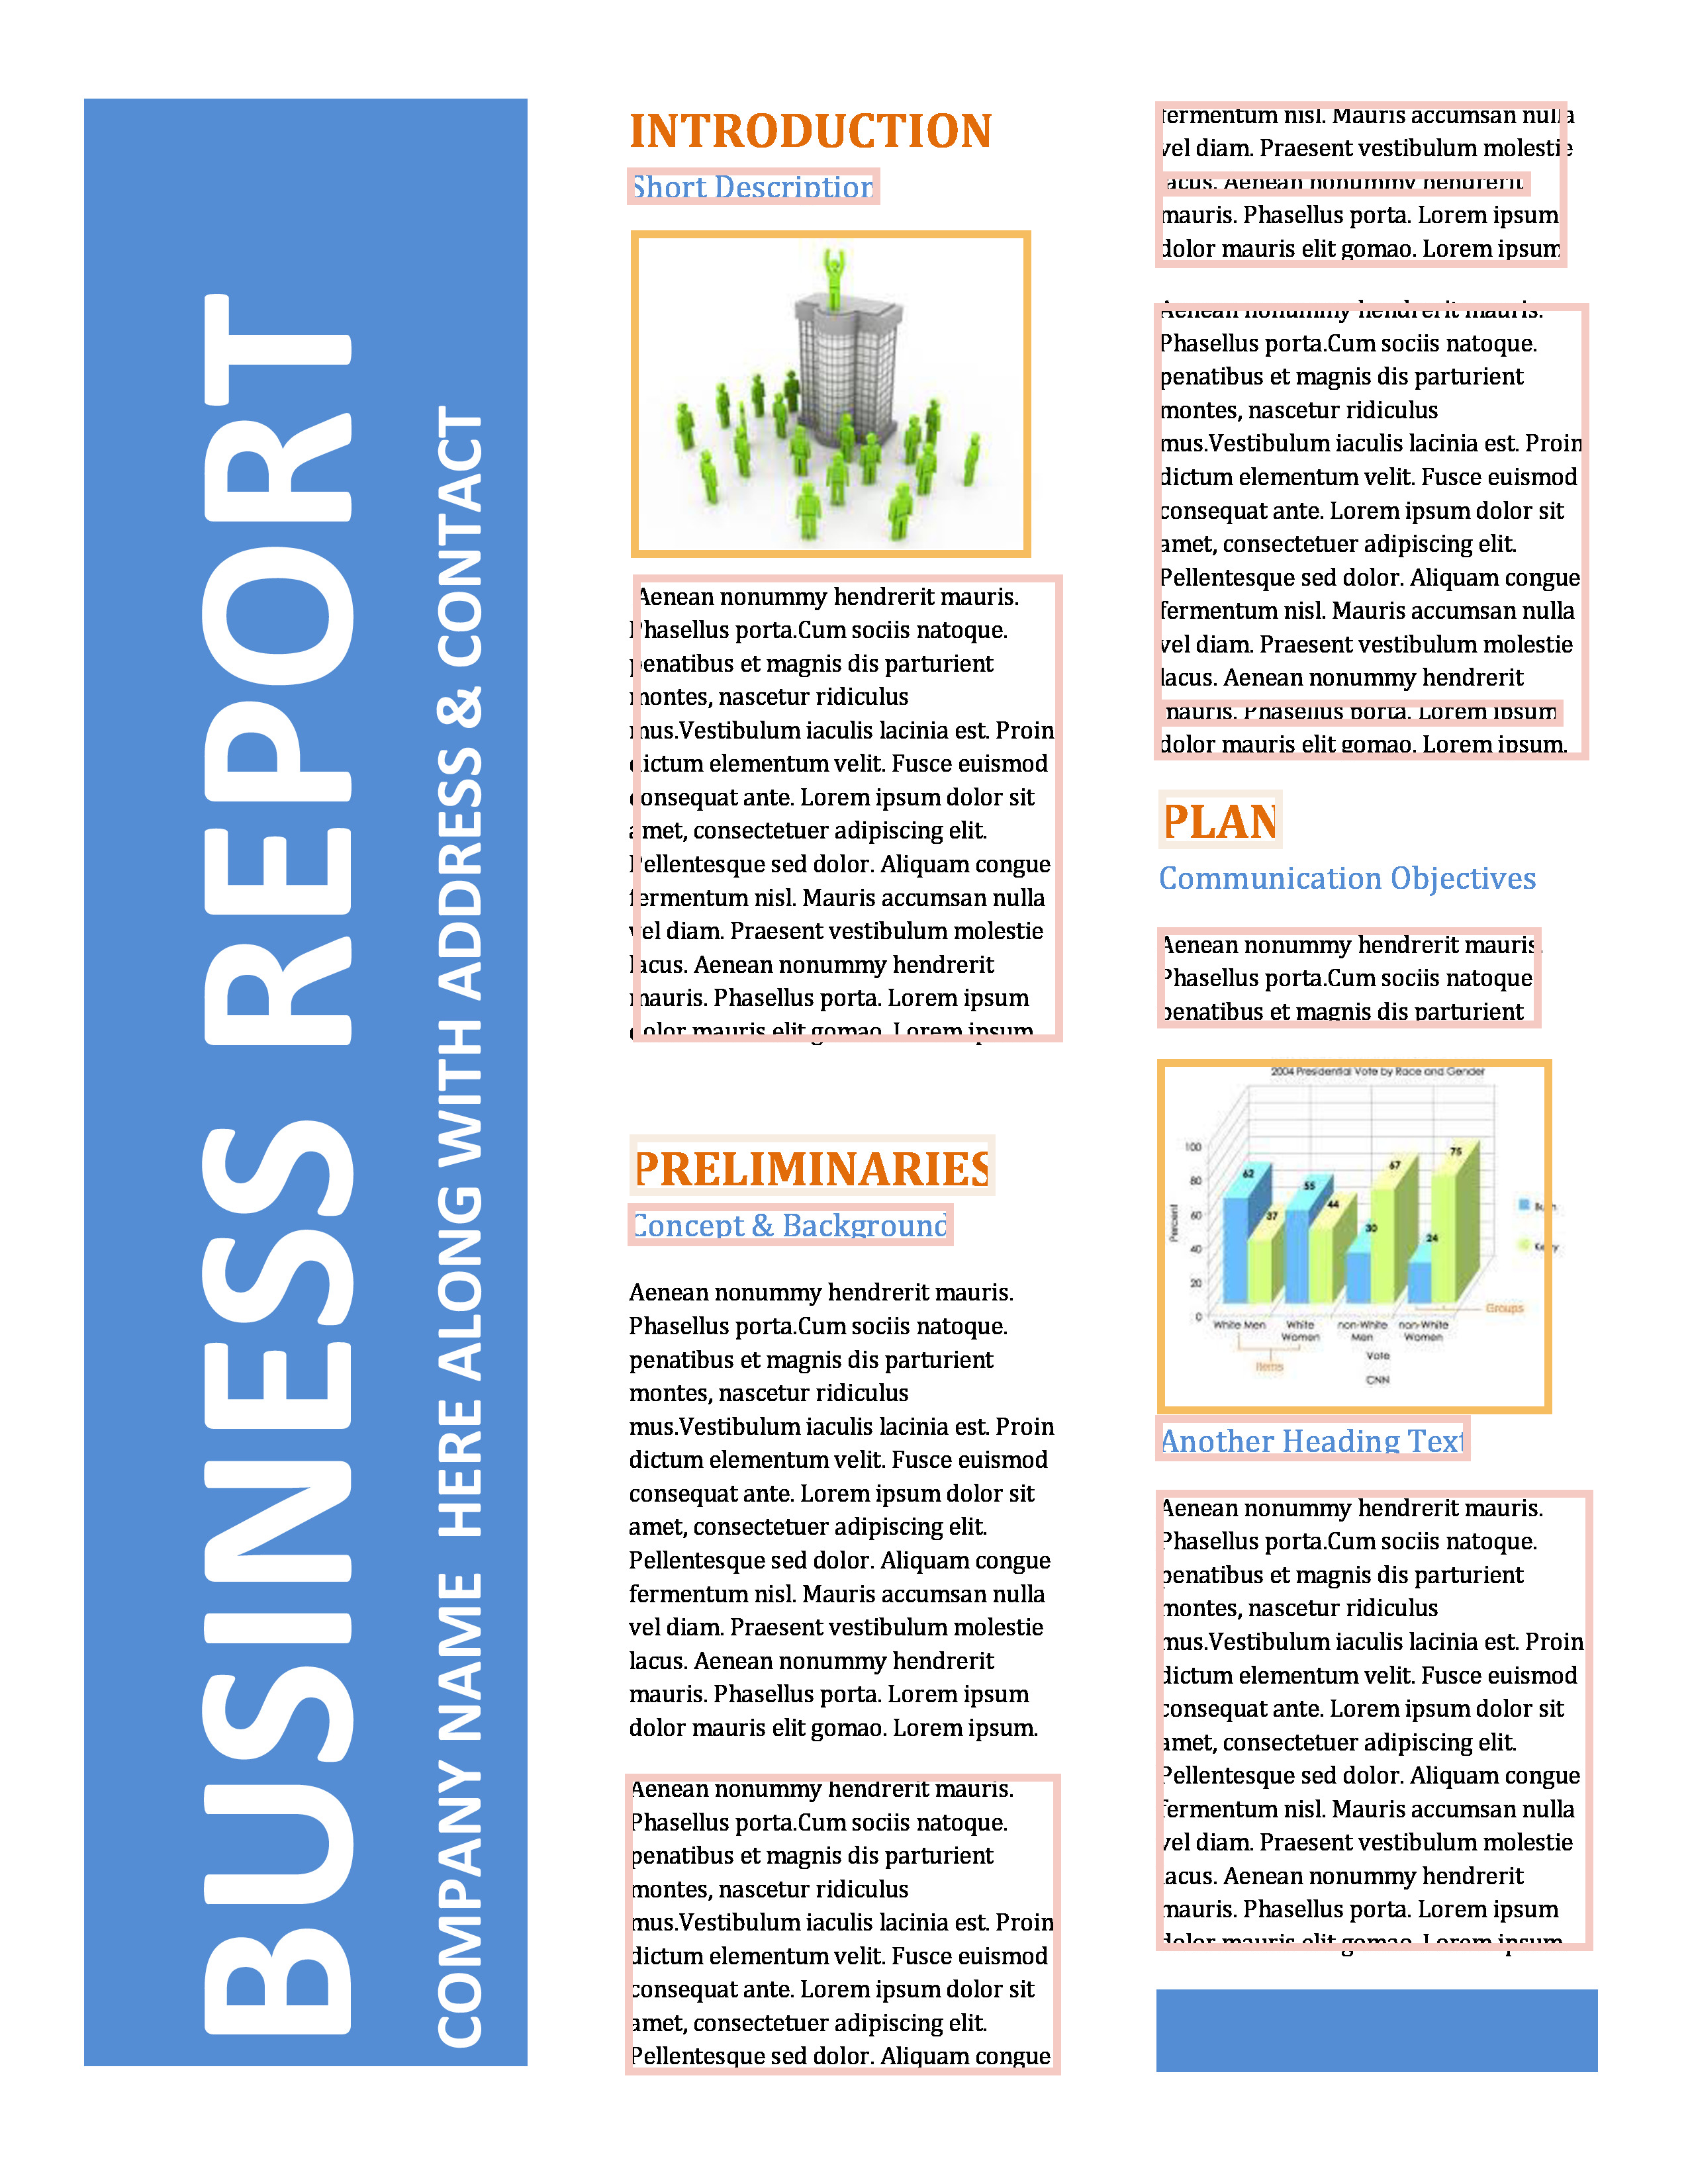

In [26]:
# Image 내 Layout 시각화
lp.draw_box(image, layout)

In [27]:
# 각 Label의 Layout Block 정의
text_blocks = lp.Layout([b for b in layout if b.type=="Text"])
title_block = lp.Layout([b for b in layout if b.type=="Title"])
list_blocks = lp.Layout([b for b in layout if b.type=='List'])
table_blocks = lp.Layout([b for b in layout if b.type=='Table'])
figure_blocks = lp.Layout([b for b in layout if b.type=='Figure'])

In [28]:
# Figure 내 Text 제거
text_blocks = lp.Layout([b for b in text_blocks \
                   if not any(b.is_in(b_fig) for b_fig in figure_blocks)])

In [29]:
h, w = image.shape[:2]

left_interval = lp.Interval(0, w/2*1.05, axis='x').put_on_canvas(image)

left_blocks = text_blocks.filter_by(left_interval, center=True)
left_blocks.sort(key = lambda b:b.coordinates[1])

right_blocks = [b for b in text_blocks if b not in left_blocks]
right_blocks.sort(key = lambda b:b.coordinates[1])

# And finally combine the two list and add the index
# according to the order
text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])

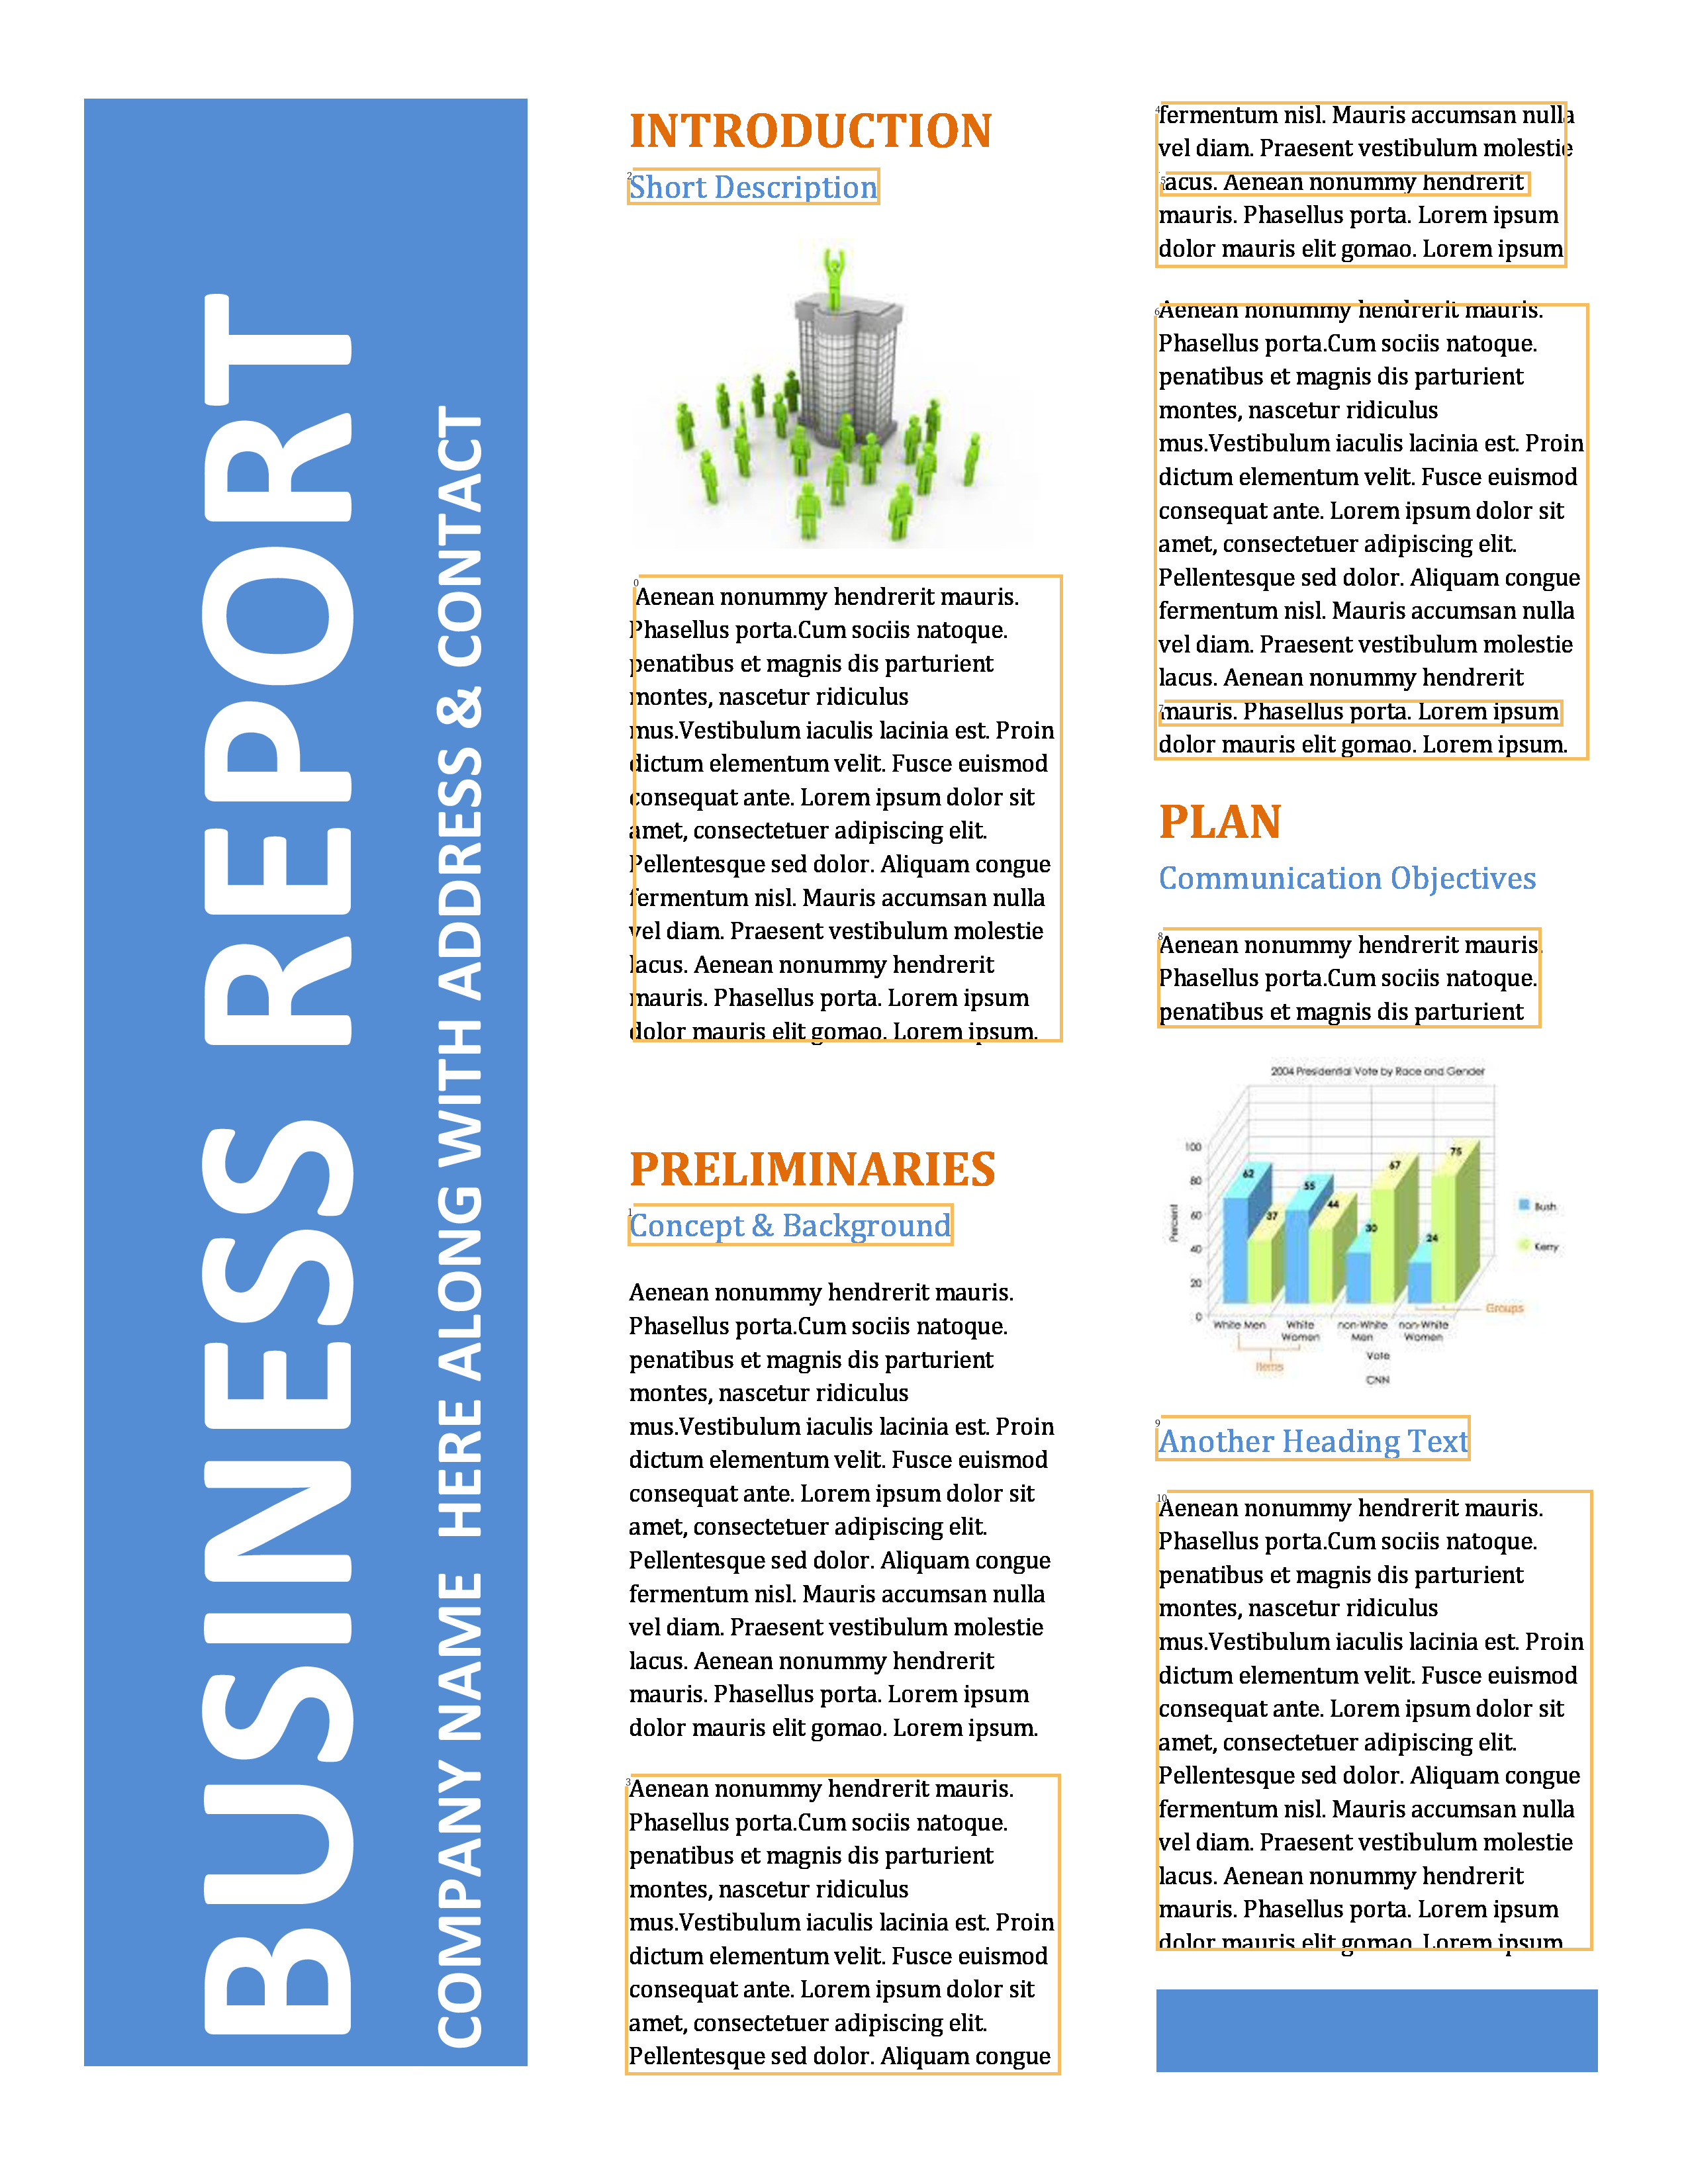

In [30]:
lp.draw_box(image,
            text_blocks,
            box_width = 5,
            show_element_id = True)

# 각 Layout 내 Text 추출을 위해 Tesseact-ocr 기술 사용

In [31]:
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.


In [32]:
# 번역 언어 = English
ocr_agent = lp.TesseractAgent(languages='eng')

In [33]:
# Box 내 Padding 정보 추가하여 글자 짤림 방지
for block in text_blocks:
    segment_image = (block.pad(left=5, right=5, top=5, bottom=5).crop_image(image))


    text = ocr_agent.detect(segment_image)
    block.set(text=text, inplace=True)

In [34]:
for txt in text_blocks.get_texts():
    print(txt, end='\n---\n')

Aenean nonummy hendrerit mauris.
Phasellus porta.Cum sociis natoque.
penatibus et magnis dis parturient
montes, nascetur ridiculus
mus.Vestibulum iaculis lacinia est. Proin
dictum elementum velit. Fusce euismod
consequat ante. Lorem ipsum dolor sit
amet, consectetuer adipiscing elit.
Pellentesque sed dolor. Aliquam congue
fermentum nisl. Mauris accumsan nulla
vel diam. Praesent vestibulum molestie
lacus. Aenean nonummy hendrerit
mauris. Phasellus porta. Lorem ipsum
dolor mauris elit gamao. Lorem ipsum.

---
Concept & Background

---
Short Description

---
Aenean nonummy hendrerit mauris.
Phasellus porta.Cum sociis natoque.
penatibus et magnis dis parturient
montes, nascetur ridiculus
mus.Vestibulum iaculis lacinia est. Proin
dictum elementum velit. Fusce euismod
consequat ante. Lorem ipsum dolor sit
amet, consectetuer adipiscing elit.
Pellentesque sed dolor. Aliquam congue

---
fermentum nisl. Mauris accumsan nulls
vel diam. Praesent vestibulum molestie
lacus. Aenean nonummy hendre

In [35]:
sentence = ["".join(txt) for txt in text_blocks.get_texts()]

In [36]:
print(sentence)

['Aenean nonummy hendrerit mauris.\nPhasellus porta.Cum sociis natoque.\npenatibus et magnis dis parturient\nmontes, nascetur ridiculus\nmus.Vestibulum iaculis lacinia est. Proin\ndictum elementum velit. Fusce euismod\nconsequat ante. Lorem ipsum dolor sit\namet, consectetuer adipiscing elit.\nPellentesque sed dolor. Aliquam congue\nfermentum nisl. Mauris accumsan nulla\nvel diam. Praesent vestibulum molestie\nlacus. Aenean nonummy hendrerit\nmauris. Phasellus porta. Lorem ipsum\ndolor mauris elit gamao. Lorem ipsum.\n\x0c', 'Concept & Background\n\x0c', 'Short Description\n\x0c', 'Aenean nonummy hendrerit mauris.\nPhasellus porta.Cum sociis natoque.\npenatibus et magnis dis parturient\nmontes, nascetur ridiculus\nmus.Vestibulum iaculis lacinia est. Proin\ndictum elementum velit. Fusce euismod\nconsequat ante. Lorem ipsum dolor sit\namet, consectetuer adipiscing elit.\nPellentesque sed dolor. Aliquam congue\n\x0c', 'fermentum nisl. Mauris accumsan nulls\nvel diam. Praesent vestibulum m